In [12]:
!pip install pytz
!pip install scikit-learn

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
import dateutil
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

Loading the data and checking out the first couple of line to check the accuracy

In [14]:
df= pd.read_csv(r"C:\Users\Ramlla\Downloads\raw_analyst_ratings.csv")
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


# Descriptive Statistics

In the following code basic descrptive assesment was done resulting with 1,407,328 data in total with no null value in any of the  columns

In [15]:
df.info() #provides us with data type amount of data and column num

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


In [16]:
df['headline_length']= df['headline'].apply(len)
df['headline_length'].describe()

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

With 1,034 publishers, it's challenging to present the number of articles published by each in a comprehensible manner. Therefore, only the top 30 publishers were selected for this analysis.

In [17]:
num_publisher=df['publisher'].nunique()
print(f'total number of publisher is: {num_publisher}')

total number of publisher is: 1034


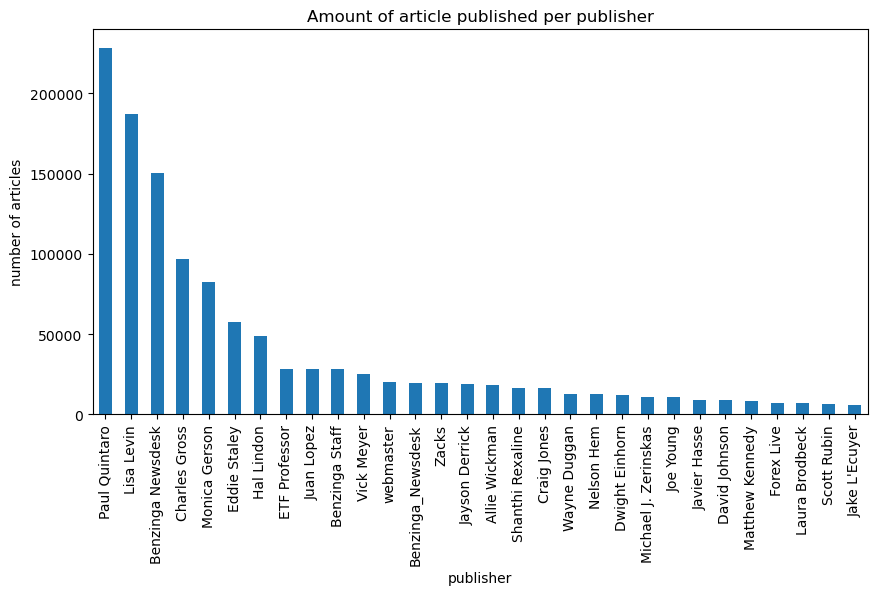

In [18]:
top_n=30
publisher_count=df['publisher'].value_counts().nlargest(top_n)
publisher_count.plot(kind='bar',figsize=(10,5))
plt.title('Amount of article published per publisher')
plt.xlabel('publisher')
plt.ylabel('number of articles')
plt.savefig('Amount of article published per publisher.png')
plt.show()


Paul Quintaro, lisa levin and Benzinga Newsdesk are the top 3 publishers.

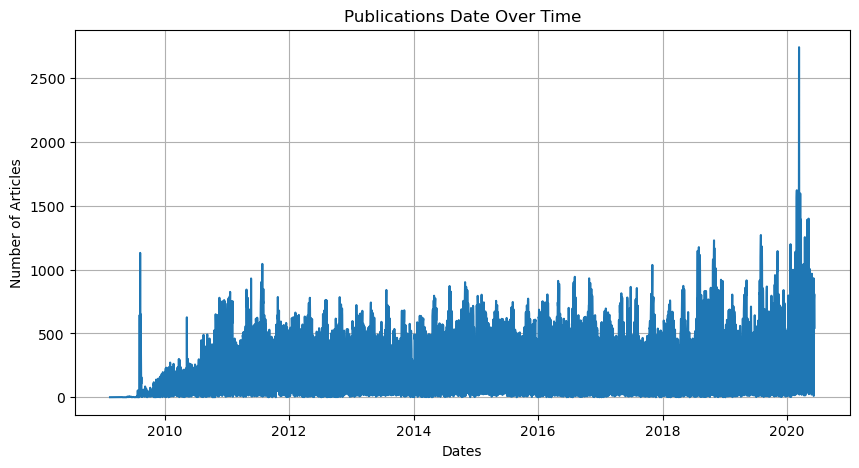

In [19]:
# Convert date column to datetime if conversion fails assisgn Nat 
#there are 3 condition if the out put is Nat, if it has a different time zone info from UTC
#and if it doesnt have time zone info it assisngs UTC time

df['publication_date'] = pd.to_datetime(df['date'], errors='coerce').apply(
                   lambda dt: dt if pd.isna(dt) 
                        else dt.astimezone(pytz.UTC) if dt.tzinfo 
                            else dt.replace(tzinfo=pytz.UTC))


# Drop rows with NaT values
df.dropna(subset=['publication_date'], inplace=True)

# Count and plot the number of articles per date
date_counts = df['publication_date'].dt.date.value_counts().sort_index()
date_counts.plot(kind='line', figsize=(10, 5))

plt.title('Publications Date Over Time')
plt.xlabel('Dates')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.savefig('Publications Date Over Time.png')
plt.show()



# Text Analysis

In [22]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

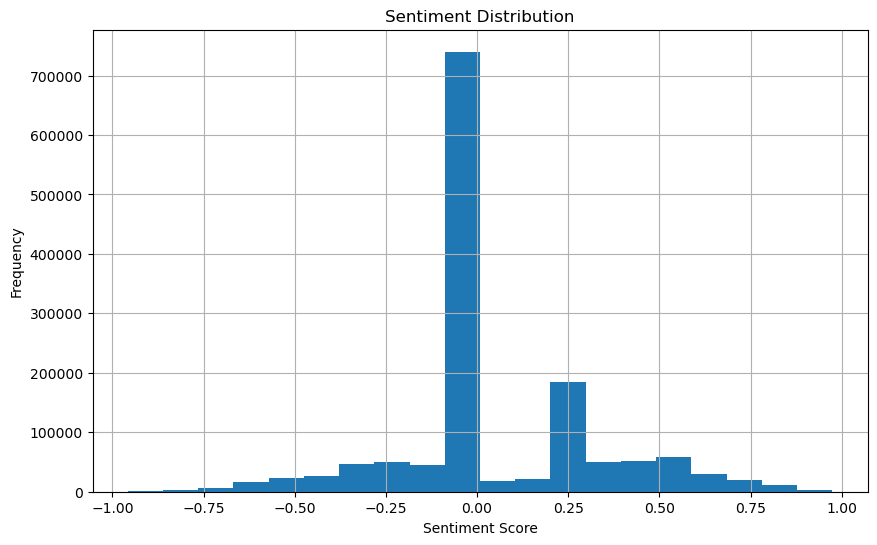

In [23]:
df['sentiment'].hist(bins=20, figsize=(10, 6))
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('Sentiment Distribution.png')
plt.show()


In [24]:
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=10)
X = vectorizer.fit_transform(df['headline'])

# Convert the results to a DataFrame
keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# Sum up the counts of each keyword
keywords_summary = keywords_df.sum().sort_values(ascending=False)
print(keywords_summary)

52 week               51006
price target          47274
stocks moving         40044
mid day               37324
market update         33101
earnings scheduled    32055
initiates coverage    28993
pre market            28393
raises pt             27213
companies trading     23170
dtype: int64


In [25]:
fda_mentions = df[df['headline'].str.contains('FDA approval', case=False, na=False)]

fda_count = fda_mentions.shape[0]

print(f"'FDA approval' mentioned {fda_count} times")


'FDA approval' mentioned 1546 times


Conclusion 
  According to the text analysis the sentiment that dominates the headline are significantly neutral and in other situation postive sentiments is greater than the negative sentiment. As for the common phrases on the headline '52 weeks', 'price target', and 'stocks moving' are among the most comment one. FDA approval is mentioned around 1546 times which is significantly lower than 'price target'.

# Publisher Analysis

Unknown                   1399240
benzinga.com                 7937
gmail.com                     139
andyswan.com                    5
investdiva.com                  2
tothetick.com                   2
eosdetroit.io                   1
forextraininggroup.com          1
stockmetrix.net                 1
Name: domain, dtype: int64


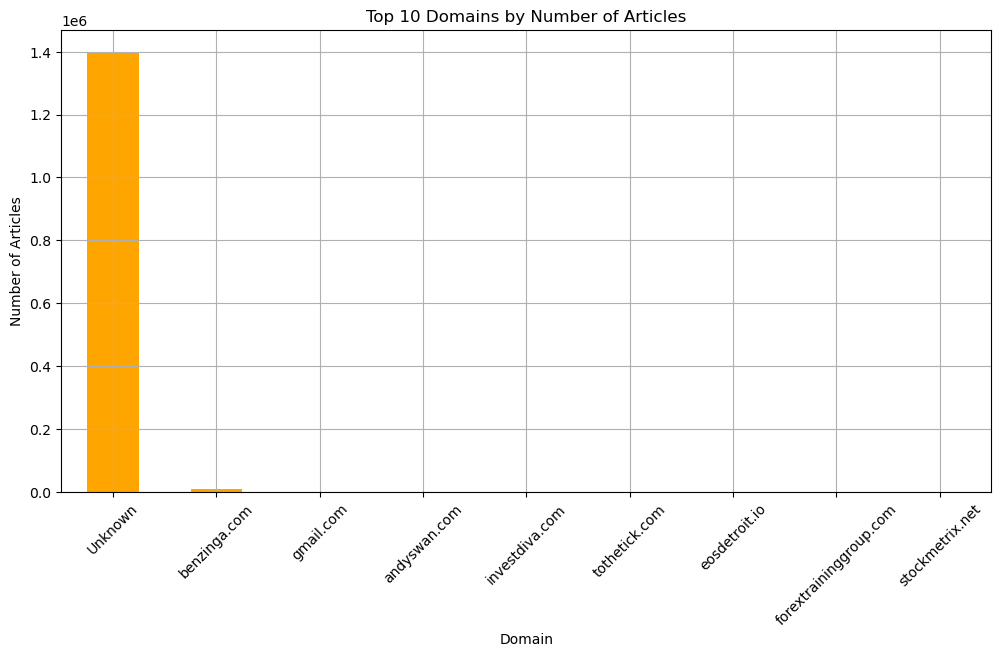

In [26]:
# Extract domains from email addresses
df['domain'] = df['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'Unknown')

# Count articles per domain
domain_counts = df['domain'].value_counts()

# Display top domains
print(domain_counts.head(10))  # Show top 10 domains



# Plot top domains
plt.figure(figsize=(12, 6))
domain_counts.head(10).plot(kind='bar', color='orange')
plt.title('Top 10 Domains by Number of Articles')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('Top 10 Domains by Number of Articles.png')
plt.show()   
